# EXPLORATORY DATA ANALYSIS of FINANCIAL DATA

## Introduction

Financial time series have unique characteristics that differentiate them from other types of data. This notebook performs an exploratory data analysis on stock price data to highlight statistical properties commonly observed in financial markets.

We'll explore:
- Basic statistical properties of returns
- Tests for normality and stationarity
- Autocorrelation patterns in returns and volatility
- Volatility clustering and persistence
- Distribution characteristics across different timeframes

## Data Loading

We'll use the `Stock` class and `loader.py` to retrieve historical price data from Yahoo Finance. The class handles downloading, cleaning, and calculating log returns automatically.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock

We can choose any valid ticker symbol for our analysis. The class will download the data from Yahoo Finance using the `yfinance` library.

In [2]:
ticker = 'AMZN'
my_stock = Stock(ticker)
my_stock.load_data()

Ticker: AMZN has 1 anomalies:
  Open-pClose Anomalies: 1


## Stock Overview

Let's first examine the basic information about our stock data:

In [3]:
print(my_stock.ticker)
print(f"Period: {my_stock.first_date.strftime('%Y-%m-%d')} to {my_stock.last_date.strftime('%Y-%m-%d')}")
print("\nSample of price data:")
print(my_stock.df.head())
print("\nLatest price data:")
print(my_stock.df.tail())

AMZN
Period: 1997-05-15 to 2025-02-25

Sample of price data:
                             Open    High     Low   Close      Volume  \
Date                                                                    
1997-05-15 00:00:00-04:00  0.1219  0.1250  0.0964  0.0979  1443120000   
1997-05-16 00:00:00-04:00  0.0984  0.0990  0.0854  0.0865   294000000   
1997-05-19 00:00:00-04:00  0.0880  0.0885  0.0812  0.0854   122136000   
1997-05-20 00:00:00-04:00  0.0865  0.0875  0.0818  0.0818   109344000   
1997-05-21 00:00:00-04:00  0.0818  0.0823  0.0688  0.0714   377064000   

                           Dividends  Stock Splits   Returns  Log_Returns  
Date                                                                       
1997-05-15 00:00:00-04:00        0.0           0.0       NaN          NaN  
1997-05-16 00:00:00-04:00        0.0           0.0 -0.116445    -0.123802  
1997-05-19 00:00:00-04:00        0.0           0.0 -0.012717    -0.012798  
1997-05-20 00:00:00-04:00        0.0           

In [4]:
# Display key company information
print("Key Information:")
print("-" * 50)
important_keys = ['shortName', 'sector', 'industry', 'marketCap', 'beta', 'trailingPE']
for key in important_keys:
    if key in my_stock.info:
        print(f"{key}: {my_stock.info[key]}")

Key Information:
--------------------------------------------------
shortName: Amazon.com, Inc.
sector: Consumer Cyclical
industry: Internet Retail
marketCap: 2255190491136
beta: 1.156
trailingPE: 38.48101


In [5]:
# Plot historical prices
fig = my_stock.plot_close(log_scale=True)
if fig:
    fig.show()

## Statistical Properties of Returns

In [9]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Financial prices are non-stationary with trends, so we analyze log returns which are more stationary and better suited for statistical analysis.

In [6]:
stock_returns = my_stock.df['Log_Returns'].dropna()

In [7]:
# Comprehensive statistics
print(f"{my_stock.ticker} Log Returns Analysis, period: {my_stock.first_date.strftime('%Y.%m.%d')} - {my_stock.last_date.strftime('%Y.%m.%d')}")
print("-" * 75)
print(f"Mean:     {stock_returns.mean():.6f}")
print(f"Median:   {stock_returns.median():.6f}")
print(f"Std Dev:  {stock_returns.std():.6f}")
print(f"Skewness: {stock_returns.skew():.6f}")
print(f"Kurtosis: {stock_returns.kurtosis():.6f}")  # Excess kurtosis
print("")
print("A skewness value deviating from zero suggests the distribution is either left-skewed (positive skewness) or right-skewed (negative skewness).")
print("Excess kurtosis significantly greater than 0 indicates the presence of heavy tails in the distribution.")

AMZN Log Returns Analysis, period: 1997.05.15 - 2025.02.25
---------------------------------------------------------------------------
Mean:     0.001100
Median:   0.000469
Std Dev:  0.034712
Skewness: 0.451066
Kurtosis: 9.617975

A skewness value deviating from zero suggests the distribution is either left-skewed (positive skewness) or right-skewed (negative skewness).
Excess kurtosis significantly greater than 0 indicates the presence of heavy tails in the distribution.


## Tests for Normality and Stationarity

Financial returns are typically characterized by peculiar features that include non-normal distribution with heavy tails and stationarity. Let's test these properties:

In [10]:
# Normality test (Jarque-Bera)
stat, p_value = stats.jarque_bera(stock_returns.dropna())
print(f"\nJarque-Bera test for normality:")
print(f"p-value: {p_value:.6f}")
print("(p-value close to 0 indicates non-normality)")

# Stationarity test (Augmented Dickey-Fuller)
adf_result = adfuller(stock_returns.dropna())
print(f"\nADF test for stationarity:")
print(f"p-value: {adf_result[1]:.6f}")
print("(p-value close to 0 indicates stationarity)")

# Autocorrelation test (Ljung-Box with lags 5, 10, 15, 20)
lb_result = acorr_ljungbox(stock_returns.dropna(), lags=[5, 10, 15, 20])
print(f"\nLjung-Box test for autocorrelation (lags 5, 10, 15, 20):")  # Tests for autocorrelation in the series
print(f"p-values: {lb_result['lb_pvalue'].values[0]:.6f} (lag 5), {lb_result['lb_pvalue'].values[1]:.6f} (lag 10), \
{lb_result['lb_pvalue'].values[2]:.6f} (lag 15), {lb_result['lb_pvalue'].values[3]:.6f} (lag 20)")
print("(p-value close to 0 indicates presence of autocorrelation)")


Jarque-Bera test for normality:
p-value: 0.000000
(p-value close to 0 indicates non-normality)

ADF test for stationarity:
p-value: 0.000000
(p-value close to 0 indicates stationarity)

Ljung-Box test for autocorrelation (lags 5, 10, 15, 20):
p-values: 0.162364 (lag 5), 0.329442 (lag 10), 0.186854 (lag 15), 0.021078 (lag 20)
(p-value close to 0 indicates presence of autocorrelation)


## Distribution Analysis

A key characteristic of financial returns is their non-normal distribution with heavy tails. Let's visualize this:

Outliers removed: 1


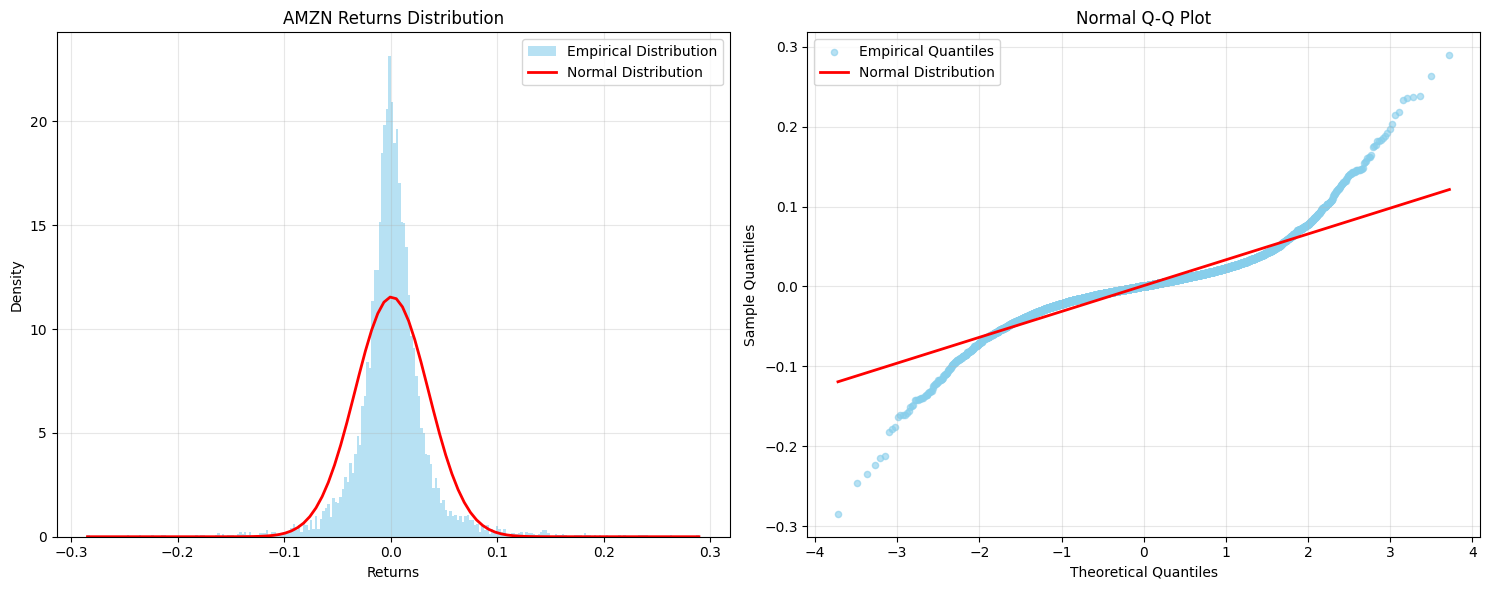

In [9]:
def remove_outliers(data, k=2):
    """
    Helper function to remove outliers using IQR method
    k: multiplier for IQR (default=2 for moderate outlier removal)
    :return: filtered data
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - k * IQR) & (data <= Q3 + k * IQR)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get both full and filtered data.
full_returns = stock_returns.dropna()
filtered_returns = remove_outliers(full_returns, k=10)

# Decide which data to use (whether the filtered or the full data)
returns = filtered_returns
if len(returns) < len(full_returns):
    print(f"Outliers removed: {len(full_returns) - len(returns)}")

# Left plot: Returns Distribution
hist, bins, _ = ax1.hist(returns.dropna(), bins=250, density=True, 
                        alpha=0.6, color='skyblue', label='Empirical Distribution')

# Add normal distribution curve
x_range = np.linspace(returns.min(), returns.max(), 100)
normal_dist = stats.norm.pdf(x_range, returns.mean(), returns.std())
ax1.plot(x_range, normal_dist, 'r-', lw=2, label='Normal Distribution')

ax1.set_title(f'{my_stock.ticker} Returns Distribution')
ax1.set_xlabel('Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Q-Q Plot
theoretical_quantiles, sample_quantiles = stats.probplot(returns.dropna(), dist="norm")[0]
slope, intercept = np.polyfit(theoretical_quantiles, sample_quantiles, 1)

ax2.scatter(theoretical_quantiles, sample_quantiles, 
           color='skyblue', alpha=0.6, s=20, label='Empirical Quantiles')

ax2.plot(theoretical_quantiles, slope * theoretical_quantiles + intercept, 
         'r-', lw=2, label='Normal Distribution')

ax2.set_title('Normal Q-Q Plot')
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### AUTOCORRELATION ANALYSIS

We will now focus on the analysis of the autocorrelation of our time series. As you may know, financial returns often exhibit autocorrelation both in the levels but also in their squares. The first level of correlation is simple to interpret: past return may affect the next returns. The second kind of autocorrelation is more subtle and many times also more persistent: the volatility (approximated by the squared returns) can have strong persistence, which means that shocks in the returns can have a long lasting effect not only on the next return but also on the volatility of the returns. This effect is often long lasting, meaning it has a long effect in the future returns.

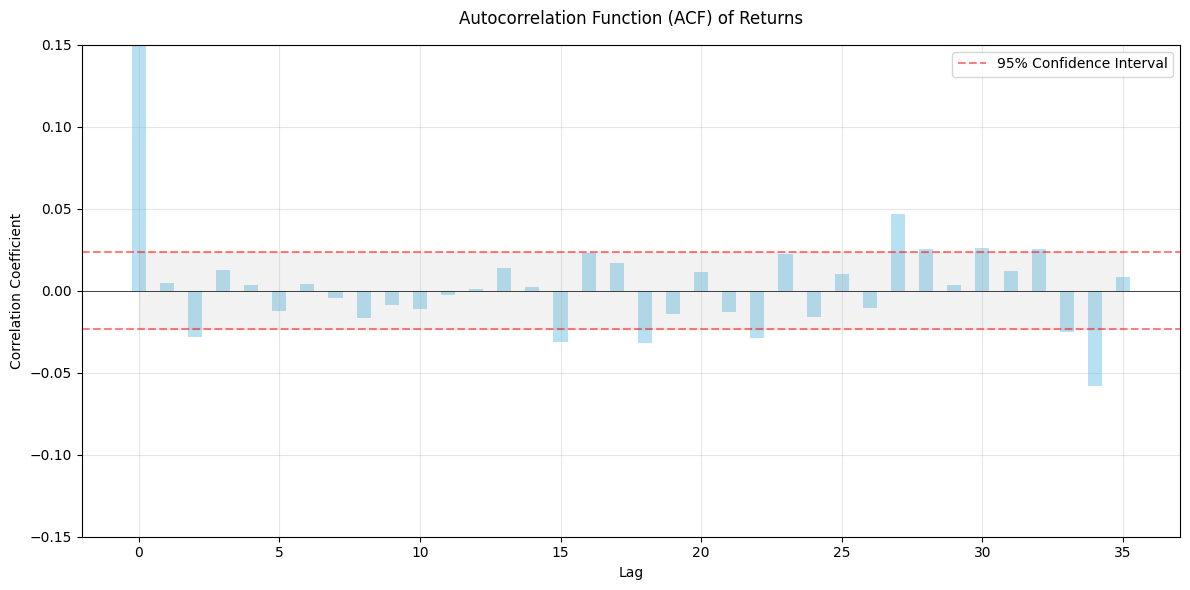


Autocorrelation Function (ACF) Values:
--------------------------------------------------
Lag        ACF Value
--------------------------------------------------
0             1.0000
1             0.0048
2            -0.0279
3             0.0129
4             0.0037
5            -0.0120
6             0.0044
7            -0.0045
8            -0.0163
9            -0.0086
10           -0.0110
11           -0.0026
12            0.0010
13            0.0140
14            0.0021
15           -0.0311
16            0.0232
17            0.0172
18           -0.0318
19           -0.0141
20            0.0113
21           -0.0130
22           -0.0291
23            0.0227
24           -0.0160
25            0.0104
26           -0.0105
27            0.0470
28            0.0258
29            0.0034
30            0.0262
31            0.0122
32            0.0252
33           -0.0252
34           -0.0579
35            0.0085


In [10]:
plt.figure(figsize=(12, 6))

# Calculate ACF values (excluding lag 0)
acf_values = acf(full_returns, nlags=35, fft=True)  # Skip lag 0
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
# Using 1.96/sqrt(n) for 95% confidence level
n = len(full_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the plot
plt.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
           label='95% Confidence Interval')
plt.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
plt.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

plt.title('Autocorrelation Function (ACF) of Returns', pad=15)
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')

# Set y-axis limits
# Use max of: 0.2 or the maximum absolute ACF value (excluding lag 0)
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
plt.ylim(-max_acf, max_acf)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Print ACF values in a formatted table
print("\nAutocorrelation Function (ACF) Values:")
print("-" * 50)
print(f"{'Lag':<8}{'ACF Value':>12}")
print("-" * 50)
for i, value in enumerate(acf_values):
    print(f"{i:<8}{value:>12.4f}")

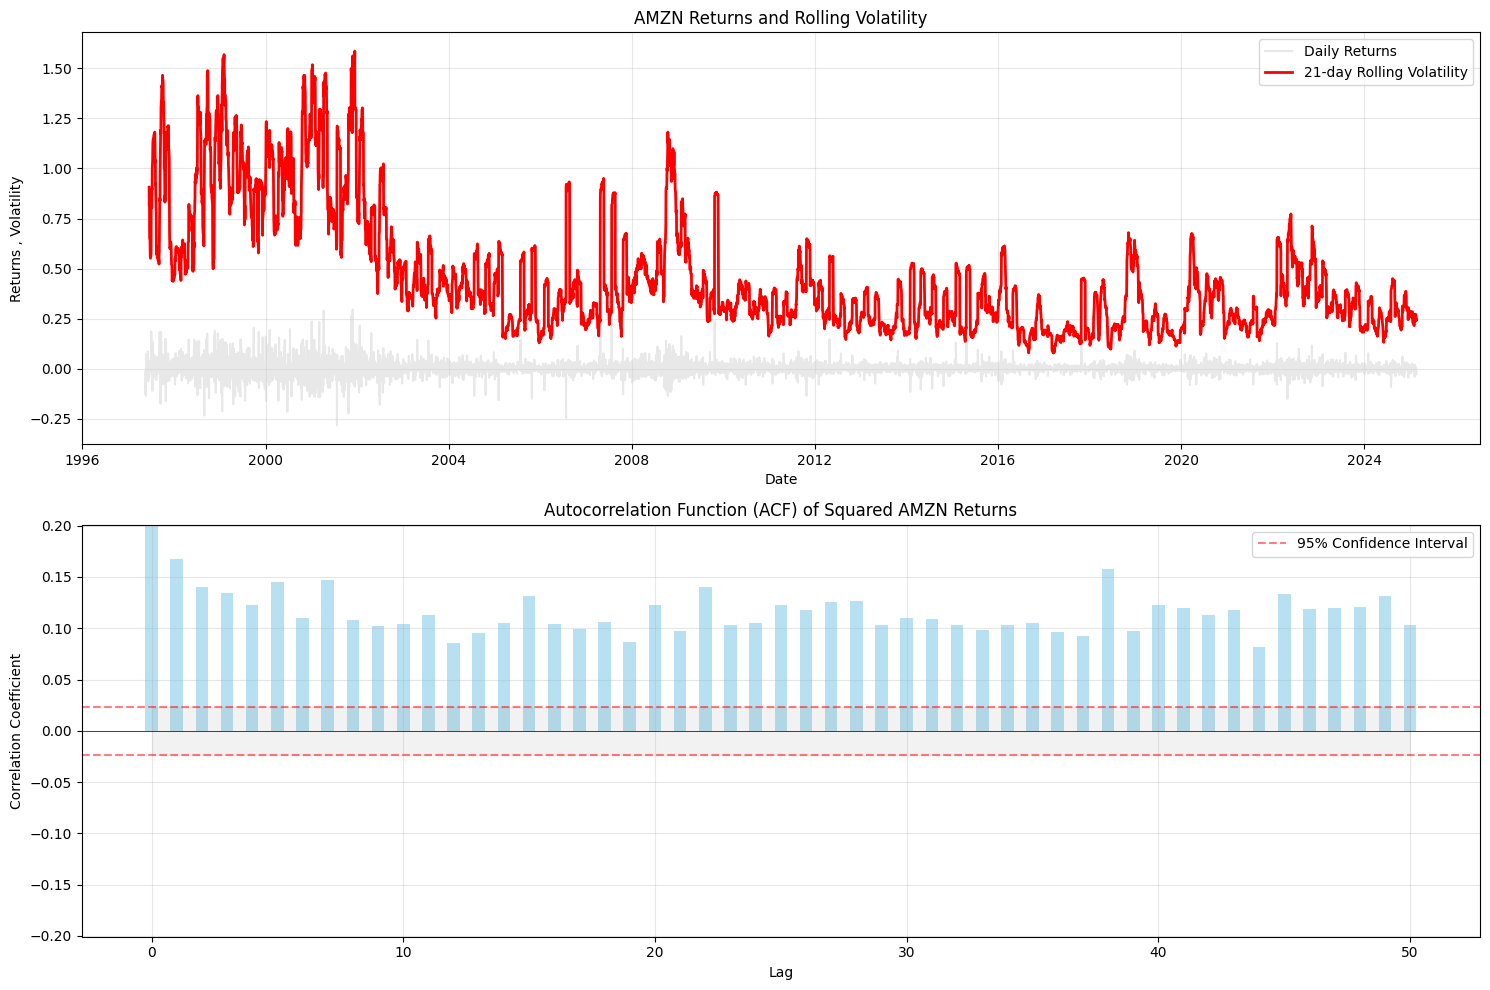

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Returns and Rolling Volatility
window = 21  # approximately one trading month
rolling_vol = full_returns.rolling(window=window).std() * np.sqrt(252)  # annualized

ax1.plot(full_returns.index, full_returns, color='lightgray', alpha=0.5, label='Daily Returns')
ax1.plot(rolling_vol.index, rolling_vol, color='red', linewidth=2, label=f'{window}-day Rolling Volatility')
ax1.set_title(f'{my_stock.ticker} Returns and Rolling Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns , Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Custom ACF of Squared Returns
squared_returns = full_returns.dropna()**2
acf_values = acf(squared_returns, nlags=50, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
n = len(squared_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the bar plot
ax2.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
            label='95% Confidence Interval')
ax2.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
ax2.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

# Set titles and labels
ax2.set_title(f'Autocorrelation Function (ACF) of Squared {my_stock.ticker} Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
ax2.set_ylim(-max_acf, max_acf)

ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()